In [5]:
from bs4 import BeautifulSoup
from datetime import datetime
from pprint import pprint
import pandas as pd
import csv

def convert_to_datetime(date_str:str):
    try:
        date_str = date_str.split(' (')[0]  # Remove the " (6 days ago)" part
        
        return datetime.strptime(date_str, '%b %d, %Y %H:%M:%S')
    except ValueError as e:
        print(f"Error parsing date: {e}")
        return None

def extract_and_save_data(html_file, csv_file):
    with open(html_file, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')
    
    data_list = []
    divs = soup.find_all('div', class_='layout row wrap')
    
    for div in divs:
        try:
            name = div.find('h3').text.strip()
            timestamp = div.find_all('div')[1].text.strip()
            mode = div.find_all('div', class_='text-center')[0].text.strip()
            power = div.find_all('div', class_='text-center')[1].text.strip()
            distance = div.find_all('div', class_='text-center')[2].text.strip()
            elevation = div.find_all('div', class_='text-center')[3].text.strip()
            rssi = div.find_all('div', class_='text-center')[4].text.strip()
            snr = div.find_all('div', class_='text-center')[5].text.strip()
            doppler = div.find_all('div', class_='text-center')[6].text.strip()
            freq_error = div.find_all('div', class_='text-center')[7].text.strip()
            received_by = div.find_all('div', class_='text-center')[9].text.strip()
            packet_url = div.find_parent('a')['href']
            
            data_list.append([name, timestamp, mode, power, distance, elevation, rssi, snr, doppler, freq_error, received_by, packet_url])
        except Exception as e:
            print(f"Skipping a div due to error: {e}")
          
    with open(csv_file, 'w', newline='', encoding='utf-8') as file:
        # header
        header = [
            'satelite', 
            'timestamp', 
            'mode_useless', 
            'frequency', 
            'power_useless', 
            'power', 
            'distance_useless', 
            'distance', 
            'elevation_useless', 
            'elevation', 
            'snr', 
            'packet_uri', 
        ]
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(data_list)
    
    print(f"Data saved to {csv_file}")


In [20]:

with open('test.html', 'r', encoding='utf-8') as file:
    soup = BeautifulSoup(file, 'html.parser')

data_list = []
df = pd.DataFrame()
divs = soup.find_all('div', class_='layout row wrap')

for div in divs:
    satelite_dict = {}
    divs_c1 = div.find_all('div')
    
    satelite_dict["satelite"] = divs_c1[0].find('h3').text
    satelite_dict["timestamp"] = divs_c1[1].text
    
    for i in range(2, len(divs_c1)):
        divs_child = divs_c1[i].find_all('div')
        if len(divs_child) > 1:
            label = divs_child[0].text
            value = divs_child[1].text
            satelite_dict[label] = value
        elif len(divs_child) == 1:
            label = divs_child[0].text
            satelite_dict[label] = None
        
    data_list.append(satelite_dict)
    df = pd.concat([df, pd.DataFrame([satelite_dict])], ignore_index=True)
    
df = df.drop(columns=[col for col in df.columns if '_useless' in col])
df["satelite"] = df["satelite"].str.replace("\n", "", regex=True).replace('- -',"")
df['timestamp'] = df['timestamp'].apply(convert_to_datetime)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df["Mode"] = df["Mode"].str.replace("LoRa@", "").replace('- -',"")
df["📻 Power"] = df["📻 Power"].str.replace("mW", "").replace("- -","")
df["📏 Distance"] = df["📏 Distance"].str.replace("Km", "").replace('- -',"")
df["📐 Elevation"] = df["📐 Elevation"].str.replace("º", "").replace('- -',"")
df["📶 RSSI"] = df["📶 RSSI"].str.replace("dBm", "").replace('- -',"")
df["SNR"] = df["SNR"].str.replace("dB", "").replace('- -',"")
df["Predicted Doppler"] = df["Predicted Doppler"].str.replace("Hz", "").replace('- -',"")
df["Frequency Error"] = df["Frequency Error"].str.replace("Hz", "").replace('- -',"")
df["CRC Error"] = df["CRC Error"].str.replace("CRC", "").replace('- -',"")
df["Received by"] = df["Received by"].str.replace("Stations", "").replace('- -',"")

df.to_csv("output.csv", index=False)
df.head(5)

,satelite,timestamp,Mode,📻 Power,📏 Distance,📐 Elevation,📶 RSSI,SNR,Predicted Doppler,Frequency Error,CRC Error,Received by
0,PICO-1B-7 ☀️,2025-03-18 12:08:57,450.1875,631,1185,22.23,-119,-5,3912.47,2267.02,\n\n,1
1,Vladivostok-1 🌜,2025-03-15 22:06:10,436.804,800,1157,19.86,-125.5,-8.5,-3188.24,-2157.97,\n\n,2
2,Vladivostok-1 🌜,2025-03-15 22:06:08,436.804,800,1152,19.98,-127.5,-10.5,-3062.16,-2325.74,\n\n,2
3,Vladivostok-1 🌜,2025-03-15 22:05:18,436.804,800,1106,21.27,-122.75,-5.75,408.71,-6163.53,\n\n,2
4,Vladivostok-1 🌜,2025-03-15 22:05:15,436.804,800,1107,21.24,-128,-10,624.37,-6301.94,\n\n,2


In [16]:
pprint(list(df.columns))

['satelite',
 'timestamp',
 'Mode',
 '📻 Power',
 '📏 Distance',
 '📐 Elevation',
 '📶 RSSI',
 'SNR',
 'Predicted Doppler',
 'Frequency Error',
 'CRC Error',
 'Received by']


In [17]:
from pprint import pprint
satelites_unique = list(df['satelite'].unique())
pprint(f'Satelites: {satelites_unique.__len__()}')
for satelite in satelites_unique:
    print(f'Satelite: {satelite}')
    # print(df[df["satelite"] == satelite].head())

'Satelites: 15'
Satelite:           PICO-1B-7 ☀️        
Satelite:           Vladivostok-1 🌜        
Satelite:           Unknown        
Satelite:           HOD-HOD-1A 🌜        
Satelite:           Tianqi-24 ☀️        
Satelite:           Tianqi-31 ☀️        
Satelite:           Tianqi-35 ☀️        
Satelite:           Tianqi-33 ☀️        
Satelite:           Tianqi-30 ☀️        
Satelite:           Tianqi-34 ☀️        
Satelite:           Tianqi ... 🤔 TLE ❌        
Satelite:           ReshUCube-2 🌜        
Satelite:           Norby ☀️        
Satelite:           Tianqi-32 ☀️        
Satelite:           Tianqi-36 ☀️        


/var/folders/qq/7rlmgyvd739ddj70pqjv0p880000gn/T/ipykernel_1118/1490413563.py:21: UserWarning: Glyph 127772 (\N{LAST QUARTER MOON WITH FACE}) missing from font(s) Arial.
  plt.savefig('packets_received_over_time.png')
/var/folders/qq/7rlmgyvd739ddj70pqjv0p880000gn/T/ipykernel_1118/1490413563.py:21: UserWarning: Glyph 9728 (\N{BLACK SUN WITH RAYS}) missing from font(s) Arial.
  plt.savefig('packets_received_over_time.png')
/var/folders/qq/7rlmgyvd739ddj70pqjv0p880000gn/T/ipykernel_1118/1490413563.py:21: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.savefig('packets_received_over_time.png')
/var/folders/qq/7rlmgyvd739ddj70pqjv0p880000gn/T/ipykernel_1118/1490413563.py:21: UserWarning: Glyph 129300 (\N{THINKING FACE}) missing from font(s) Arial.
  plt.savefig('packets_received_over_time.png')
/var/folders/qq/7rlmgyvd739ddj70pqjv0p880000gn/T/ipykernel_1118/1490413563.py:21: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.s

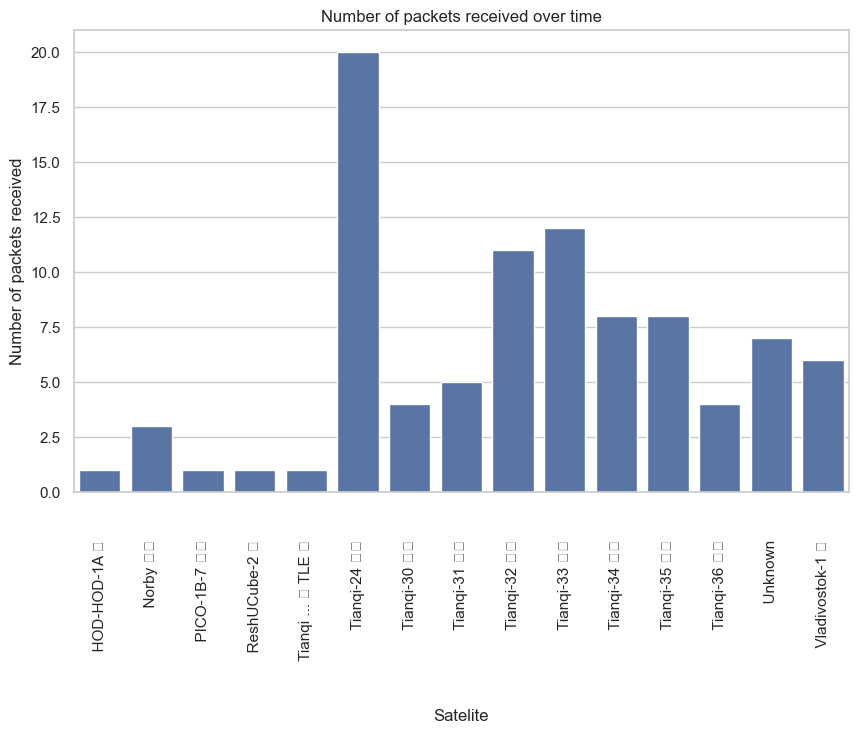

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# plot stelite names and count
satelites_unique = list(df['satelite'].unique())
satelites_unique.sort()
# plot using seaborne
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
# plot the number of packets received over time
sns.countplot(data=df, x='satelite', order=satelites_unique)
plt.xticks(rotation=90)
plt.xlabel('Satelite')
plt.ylabel('Number of packets received')
plt.title('Number of packets received over time')
# plt.tight_layout()
plt.savefig('packets_received_over_time.png')
plt.show()


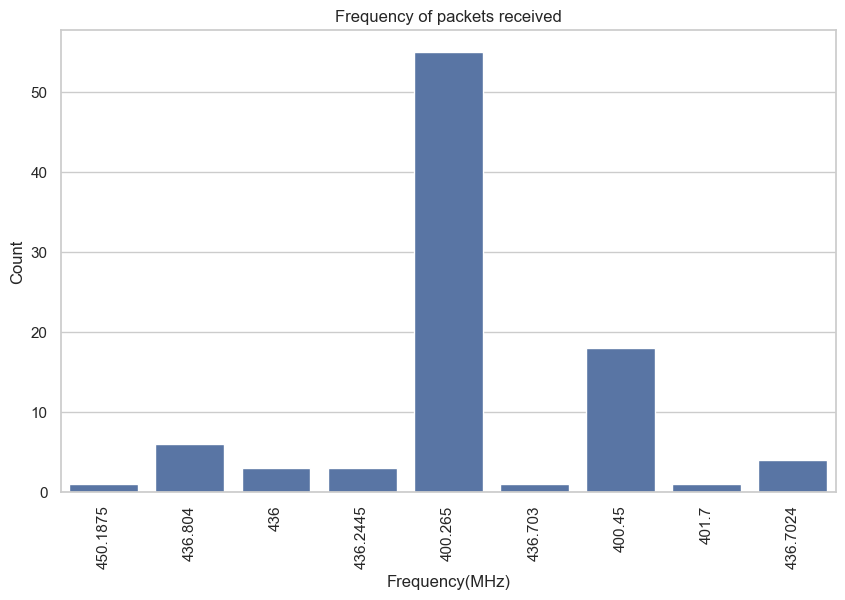

In [ ]:
# value plot df["Mode"]
# plot using seaborne
plt.figure(figsize=(10, 6))
# plot the number of packets received over time
sns.countplot(data=df, x='Mode')
plt.xticks(rotation=90)
plt.xlabel('Frequency(MHz)')
plt.ylabel('Count')
plt.title('Frequency of packets received')
# plt.tight_layout()
# plt.savefig('packets_received_over_time.png')
plt.show()

In [29]:
df.columns

Index(['satelite', 'timestamp', 'Mode', '📻 Power', '📏 Distance', '📐 Elevation',
       '📶 RSSI', 'SNR', 'Predicted Doppler', 'Frequency Error', 'CRC Error',
       'Received by'],
      dtype='object')

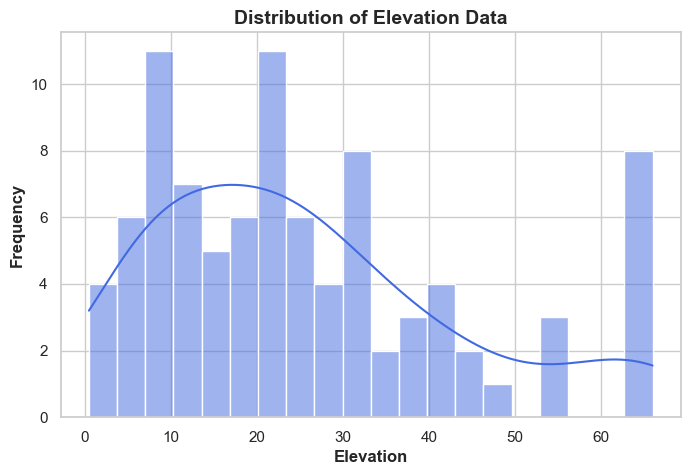

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert column to numeric (if it's not already)
df["📐 Elevation"] = pd.to_numeric(df["📐 Elevation"], errors="coerce")

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(df["📐 Elevation"], bins=20, kde=True, color="royalblue")

# Formatting
plt.xlabel("Elevation", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("Distribution of Elevation Data", fontsize=14, fontweight="bold")

plt.show()


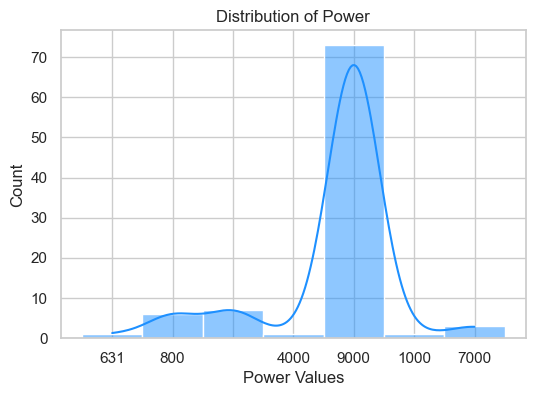

In [44]:
# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(df["📻 Power"], bins=10, kde=True, color="dodgerblue")

plt.xlabel("Power Values")
plt.ylabel("Count")
plt.title("Distribution of Power")

plt.show()


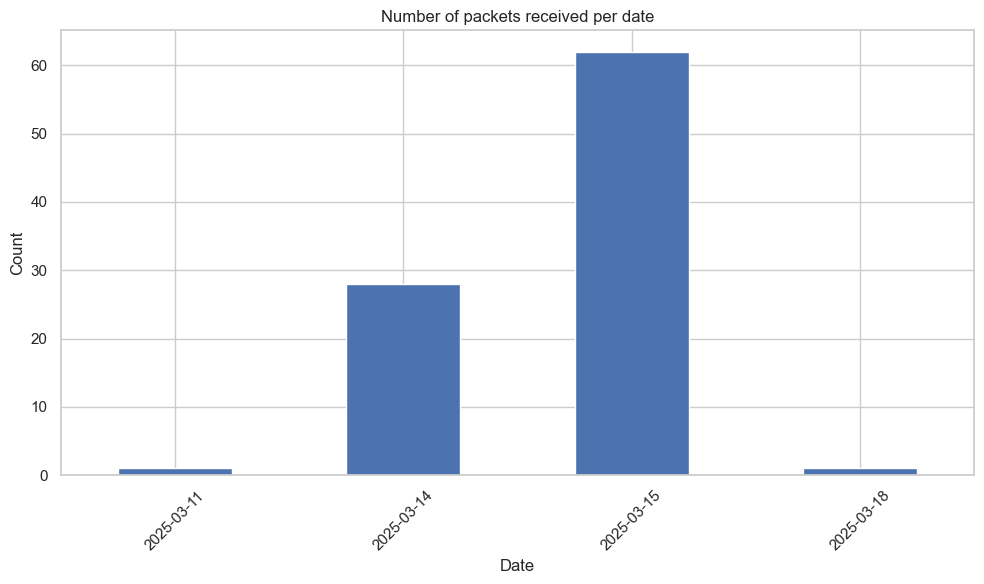

In [35]:
df["timestamp"].dt.date.value_counts().sort_index().plot(kind='bar', figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Number of packets received per date")
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('packets_received_per_date.png')
plt.show()

In [36]:
df['timestamp'].describe()

count                               92
mean     2025-03-15 10:03:23.673913088
min                2025-03-11 21:38:59
25%      2025-03-14 17:05:40.750000128
50%         2025-03-15 15:37:26.500000
75%      2025-03-15 20:08:53.750000128
max                2025-03-18 12:08:57
Name: timestamp, dtype: object

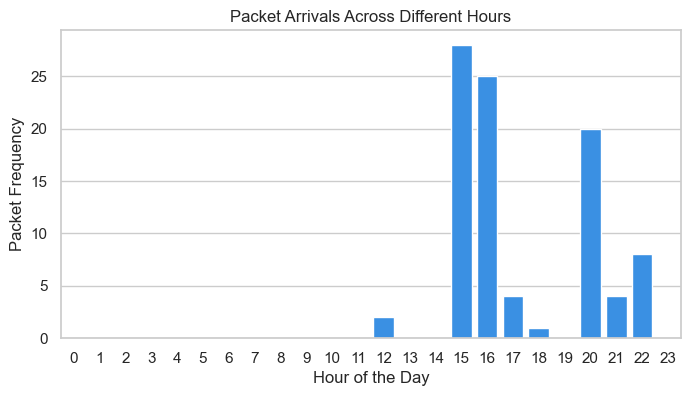

In [39]:
df["hour"] = df["timestamp"].dt.hour

# Count occurrences per hour
hourly_counts = df["hour"].value_counts().sort_index()

# Create a full range of 24 hours to ensure empty hours show up as zero
all_hours = pd.Series(index=range(24), data=0)
hourly_counts = all_hours.add(hourly_counts, fill_value=0)

# Plot the hourly distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color="dodgerblue")

# Formatting
plt.xlabel("Hour of the Day")
plt.ylabel("Packet Frequency")
plt.title("Packet Arrivals Across Different Hours")
plt.xticks(range(0, 24))

plt.show()


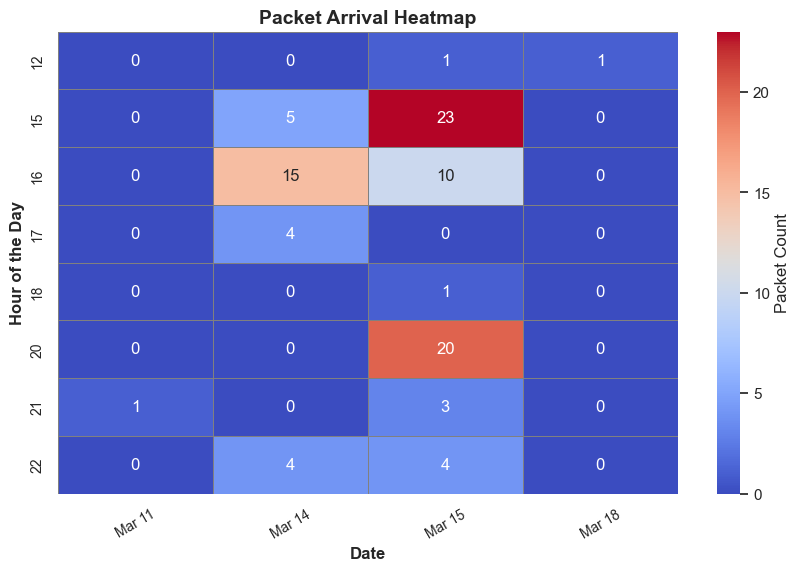

In [43]:

# Extract day and hour
df["day"] = df["timestamp"].dt.strftime('%b %d')  # Format day as 'Mar 11'
df["hour"] = df["timestamp"].dt.hour  # Extract hour

# Create a pivot table (Hours as rows, Days as columns)
heatmap_data = df.groupby(["hour", "day"]).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data, 
    cmap="coolwarm",   # Better contrast (cool to warm shades)
    annot=True,        # Show exact counts
    fmt="d",           # Integer format
    linewidths=0.5,    # Light gridlines for readability
    linecolor='gray',  # Grid color
    cbar_kws={'label': 'Packet Count'}  # Color bar label
)

# Styling
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Hour of the Day", fontsize=12, fontweight="bold")
plt.title("Packet Arrival Heatmap", fontsize=14, fontweight="bold")
plt.xticks(fontsize=10, rotation=30)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Keep hour labels readable

plt.show()


In [5]:
import pandas as pd

# Load CSV file
file_path = "refined.csv"  # Update with your actual file path
df = pd.read_csv(file_path, delimiter=",", header=None)

# Rename columns for clarity
df.columns = [
    "Name", "Timestamp", "Mode", "Frequency", "Power_Label", "Power", 
    "Distance_Label", "Distance", "Elevation_Label", "Elevation", "RSSI", "Packet_URL"
]

# Drop unnecessary label columns
df = df.drop(columns=["Power_Label", "Distance_Label", "Elevation_Label"])

# Clean and convert data types
df["Distance"] = pd.to_numeric(df["Distance"].str.replace("Km", "").replace("- -", None), errors='coerce')
df["Elevation"] = pd.to_numeric(df["Elevation"].str.replace("º", "").replace("- -", None), errors='coerce')
df["Power"] = pd.to_numeric(df["Power"].str.replace("mW", "").replace("- -", None), errors='coerce')
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')

# Sort by Timestamp
df = df.sort_values(by="Timestamp")

# Insights
closest_satellite = df.loc[df["Distance"].idxmin()]
latest_satellite = df.iloc[-1]

print("Closest Satellite:\n", closest_satellite)
print("\nLatest Satellite Activity:\n", latest_satellite)


Closest Satellite:
 Name                                               Unknown
Timestamp                                              NaT
Mode                                                  Mode
Frequency                                    LoRa@436.2445
Power                                                  NaN
Distance                                             525.0
Elevation                                            63.12
RSSI                                           -120.25 dBm
Packet_URL    /packet/992d696b-c056-49eb-8825-dd939668c3e0
Name: 6, dtype: object

Latest Satellite Activity:
 Name                                               Unknown
Timestamp                                              NaT
Mode                                                  Mode
Frequency                                    LoRa@436.2445
Power                                                  NaN
Distance                                             580.0
Elevation                                  

/var/folders/qq/7rlmgyvd739ddj70pqjv0p880000gn/T/ipykernel_25092/3388300476.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')


In [1]:
! pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 104.4 kB/s eta 0:00:0000:0200:05

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

# Set up Selenium WebDriver (use the appropriate driver)
driver = webdriver.Firefox()  # For Firefox, use webdriver.Firefox()

# Initialize an empty list to store extracted data
data_list = []

# Loop through each URL in the DataFrame
for index, row in df.iterrows():
    url = row["Packet URL"]
    driver.get(url)
    time.sleep(5)  # Allow time for the page to load

    try:
        # Extract hexadecimal view data
        hex_view_element = driver.find_element(By.XPATH, "//div[contains(text(), 'Hexadecimal view')]/following-sibling::div")
        hex_data = hex_view_element.text if hex_view_element else "N/A"

        # Extract raw parsed view data
        raw_parsed_element = driver.find_element(By.XPATH, "//div[contains(text(), 'Raw parsed view')]/following-sibling::div")
        raw_data = raw_parsed_element.text if raw_parsed_element else "N/A"

        # Extract metadata (Station Name, Distance, Elevation, Time, etc.)
        station_element = driver.find_element(By.XPATH, "//div[contains(@class, 'station-name')]")
        station_name = station_element.text if station_element else "N/A"

        distance_element = driver.find_element(By.XPATH, "//div[contains(text(), 'Distance')]/following-sibling::div")
        distance = distance_element.text if distance_element else "N/A"

        elevation_element = driver.find_element(By.XPATH, "//div[contains(text(), 'Elevation')]/following-sibling::div")
        elevation = elevation_element.text if elevation_element else "N/A"

        time_element = driver.find_element(By.XPATH, "//div[contains(text(), 'Time')]/following-sibling::div")
        timestamp = time_element.text if time_element else "N/A"

        # Append data to list
        data_list.append({
            "url": url,
            "station_name": station_name,
            "distance": distance,
            "elevation": elevation,
            "time": timestamp,
            "hex_data": hex_data,
            "raw_data": raw_data
        })

    except Exception as e:
        print(f"Error processing {url}: {e}")

# Convert to DataFrame
result_df = pd.DataFrame(data_list)

# Save to CSV
result_df.to_csv("tinygs_extracted_data.csv", index=False)

# Close the browser
driver.quit()

# Display the extracted DataFrame
print(result_df.head())


NoSuchDriverException: Message: Unable to obtain driver for firefox; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location
